Follow this guide before running this notebook: https://tillbeemelmanns.github.io/2020/10/10/convert-cityscapes-to-coco-dataset-format.html

In [4]:
import os
import json
import shutil

In [5]:
# Directories (adjust paths as necessary)
json_train_path = "data/cityscapes/annotations/instancesonly_filtered_gtFine_train.json"
json_val_path = "data/cityscapes/annotations/instancesonly_filtered_gtFine_val.json"
image_train_dir = "data/cityscapes/leftImg8bit/train"
image_val_dir = "data/cityscapes/leftImg8bit/val"
output_dir = "data/yolo_format"

# Create directories for output
os.makedirs(f"{output_dir}/train", exist_ok=True)
os.makedirs(f"{output_dir}/test", exist_ok=True)
os.makedirs(f"{output_dir}/val", exist_ok=True)

In [6]:
from tqdm import tqdm

# Helper function to convert bounding box to YOLO format
def convert_bbox_to_yolo(image_width, image_height, bbox):
    x, y, width, height = bbox
    x_center = (x + width / 2) / image_width
    y_center = (y + height / 2) / image_height
    width_normalised = width / image_width
    height_normalised = height / image_height
    return x_center, y_center, width_normalised, height_normalised

# Function to process annotations and copy images
def process_annotations(json_path, image_dir, output_dir):
    with open(json_path, "r") as f:
        data = json.load(f)

    # Create a dictionary for images
    images = {img["id"]: img for img in data["images"]}
    
    for annotation in tqdm(data["annotations"]):
        image_id = annotation["image_id"]
        image_info = images[image_id]
        image_width = image_info["width"]
        image_height = image_info["height"]

        # Convert bbox to YOLO format
        bbox = annotation["bbox"]
        x_center, y_center, w, h = convert_bbox_to_yolo(image_width, image_height, bbox)

        # Generate paths for annotation and image
        image_file_name = os.path.basename(image_info["file_name"])
        city = image_file_name.split('_')[0]
        annotation_file = os.path.join(output_dir, "labels", f"{os.path.splitext(image_file_name)[0]}.txt")
        image_source_file = os.path.join(image_dir, city, image_file_name)
        image_target_file = os.path.join(output_dir, "images", image_file_name)

        # Ensure output directories exist
        os.makedirs(os.path.dirname(annotation_file), exist_ok=True)
        os.makedirs(os.path.dirname(image_target_file), exist_ok=True)

        # Write annotation to the YOLO file
        category_id = annotation["category_id"] - 1  # Ensure category IDs start at 0
        with open(annotation_file, "a") as f:
            f.write(f"{category_id} {x_center} {y_center} {w} {h}\n")
        
        # Copy the image to the output directory
        if not os.path.exists(image_target_file):
            shutil.copy(image_source_file, image_target_file)

# Process train and val annotations
process_annotations(json_train_path, image_train_dir, os.path.join(output_dir, "train"))
process_annotations(json_val_path, image_val_dir, os.path.join(output_dir, "val"))

print("YOLO annotations and images have been processed successfully.")

100%|██████████| 9792/9792 [00:01<00:00, 7201.86it/s]

YOLO annotations and images have been processed successfully.


In [7]:
import random

# Function to move 500 random images and labels to the test directory
def move_to_test_directory(train_dir, test_dir, num_files=500):
    image_dir = os.path.join(train_dir, "images")
    label_dir = os.path.join(train_dir, "labels")
    test_image_dir = os.path.join(test_dir, "images")
    test_label_dir = os.path.join(test_dir, "labels")
    
    # Ensure test directories exist
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_label_dir, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png") or f.endswith(".jpg")]
    
    # Randomly select files
    selected_files = random.sample(image_files, num_files)
    
    for file_name in tqdm(selected_files, desc="Moving files to test directory"):
        # Move image
        source_image = os.path.join(image_dir, file_name)
        target_image = os.path.join(test_image_dir, file_name)
        shutil.move(source_image, target_image)
        
        # Move corresponding label
        label_file = f"{os.path.splitext(file_name)[0]}.txt"
        source_label = os.path.join(label_dir, label_file)
        target_label = os.path.join(test_label_dir, label_file)
        shutil.move(source_label, target_label)

move_to_test_directory(os.path.join(output_dir, "train"), os.path.join(output_dir, "test"), num_files=500)


Moving files to test directory: 100%|██████████| 500/500 [00:00<00:00, 12828.74it/s]


In [8]:
import json

# Path to the JSON annotation file and the output class file
json_path = "data/cityscapes/annotations/instancesonly_filtered_gtFine_train.json"
class_file_path = "data/yolo_format/classes.names"

# Function to extract categories and save to a class file
def generate_class_file(json_path, class_file_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    
    # Extract categories
    categories = data["categories"]
    category_names = [category["name"] for category in sorted(categories, key=lambda x: x["id"])]

    # Write class names to file
    with open(class_file_path, "w+") as f:
        for category_name in category_names:
            f.write(f"{category_name}\n")
    
    print(f"Class file created at {class_file_path}")

# Generate the class file
generate_class_file(json_path, class_file_path)


Class file created at data/yolo_format/classes.names


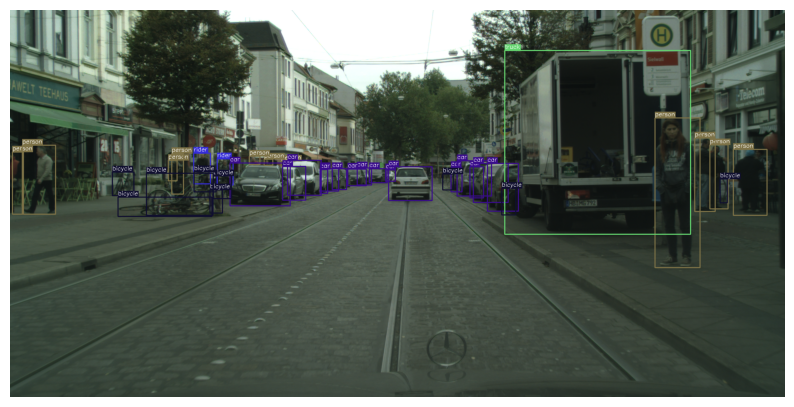

In [9]:
import cv2
import matplotlib.pyplot as plt
import random

# Function to generate random colors for each class
def generate_colors(class_names):
    random.seed(42)  # For consistent colours
    return {class_name: [random.randint(0, 255) for _ in range(3)] for class_name in class_names}

# Function to plot bounding boxes with class names and colours
def plot_bounding_boxes_with_colours(image_path, annotation_path, class_names_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Read class names
    with open(class_names_path, "r") as f:
        class_names = [line.strip() for line in f.readlines()]
    
    # Generate colours for each class
    class_colours = generate_colors(class_names)
    
    # Read YOLO annotations
    with open(annotation_path, "r") as f:
        annotations = f.readlines()
    
    # Get image dimensions
    image_height, image_width, _ = image.shape
    
    # Draw bounding boxes
    for annotation in annotations:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, annotation.split())
        class_name = class_names[int(class_id)]
        colour = class_colours[class_name]
        
        # Convert YOLO format to pixel coordinates
        x_center *= image_width
        y_center *= image_height
        bbox_width *= image_width
        bbox_height *= image_height
        
        x1 = int(x_center - bbox_width / 2)
        y1 = int(y_center - bbox_height / 2)
        x2 = int(x_center + bbox_width / 2)
        y2 = int(y_center + bbox_height / 2)
        
        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), colour, 2)
        
        # Add class name with background rectangle for readability
        label = f"{class_name}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        label_x1 = x1
        label_y1 = y1 - label_size[1] - 4
        label_x2 = x1 + label_size[0]
        label_y2 = y1
        cv2.rectangle(image, (label_x1, label_y1), (label_x2, label_y2), colour, -1)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
image_path = "data/yolo_format/train/images/bremen_000099_000019_leftImg8bit.png"
annotation_path = "data/yolo_format/train/labels/bremen_000099_000019_leftImg8bit.txt"
class_names_path = "data/yolo_format/classes.names"

plot_bounding_boxes_with_colours(image_path, annotation_path, class_names_path)


In [10]:
import cv2
import os
from tqdm import tqdm

def resize_images(input_dir, output_dir, target_size):
    os.makedirs(output_dir, exist_ok=True)
    for file_name in tqdm(os.listdir(input_dir), desc=f"Resizing images in {input_dir}"):
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)
        
        # Read and resize image
        image = cv2.imread(input_path)
        if image is None:
            continue
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        
        # Save resized image
        cv2.imwrite(output_path, resized_image)

# Directories
train_dir = "data/yolo_format/train/images"
val_dir = "data/yolo_format/val/images"
test_dir = "data/yolo_format/test/images"

output_train_dir = "data/yolo_format/train/images_resized"
output_val_dir = "data/yolo_format/val/images_resized"
output_test_dir = "data/yolo_format/test/images_resized"

# Create directories for output
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_val_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Target size (width, height) - Adjust as needed
target_size = (1024, 512)

# Resize images
resize_images(train_dir, output_train_dir, target_size)
resize_images(val_dir, output_val_dir, target_size)
resize_images(test_dir, output_test_dir, target_size)


Resizing images in data/yolo_format/test/images: 100%|██████████| 500/500 [00:40<00:00, 12.28it/s]


In [11]:
import os
import shutil

# Paths to original image folders
original_train_dir = "data/yolo_format/train/images"
original_val_dir = "data/yolo_format/val/images"
original_test_dir = "data/yolo_format/test/images"

# Paths to resized folders
resized_train_dir = "data/yolo_format/train/images_resized"
resized_val_dir = "data/yolo_format/val/images_resized"
resized_test_dir = "data/yolo_format/test/images_resized"

# Function to remove a folder
def remove_folder(folder_path):
    if os.path.exists(folder_path):
        print(f"Removing folder: {folder_path}")
        shutil.rmtree(folder_path)
    else:
        print(f"Folder not found: {folder_path}")

# Function to rename a folder
def rename_folder(src, dest):
    if os.path.exists(src):
        print(f"Renaming folder: {src} -> {dest}")
        os.rename(src, dest)
    else:
        print(f"Folder not found: {src}, cannot rename.")

# Remove original folders
remove_folder(original_train_dir)
remove_folder(original_val_dir)
remove_folder(original_test_dir)

# Rename resized folders to replace the original folder names
rename_folder(resized_train_dir, original_train_dir)
rename_folder(resized_val_dir, original_val_dir)
rename_folder(resized_test_dir, original_test_dir)

print("Folders have been successfully removed and renamed.")


Removing folder: data/yolo_format/train/images
Removing folder: data/yolo_format/val/images
Removing folder: data/yolo_format/test/images
Renaming folder: data/yolo_format/train/images_resized -> data/yolo_format/train/images
Renaming folder: data/yolo_format/val/images_resized -> data/yolo_format/val/images
Renaming folder: data/yolo_format/test/images_resized -> data/yolo_format/test/images
Folders have been successfully removed and renamed.
